In [47]:
import re
import string
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report



import warnings
warnings.filterwarnings("ignore")

In [3]:
df= pd.read_csv('/content/train.csv')

Text Analysis

In [4]:
df.head(10).style.background_gradient(cmap='coolwarm')

,id,keyword,location,text,target
0,1,nan,nan,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,nan,nan,Forest fire near La Ronge Sask. Canada,1
2,5,nan,nan,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,nan,nan,"13,000 people receive #wildfires evacuation orders in California",1
4,7,nan,nan,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
5,8,nan,nan,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1
6,10,nan,nan,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1
7,13,nan,nan,I'm on top of the hill and I can see a fire in the woods...,1
8,14,nan,nan,There's an emergency evacuation happening now in the building across the street,1
9,15,nan,nan,I'm afraid that the tornado is coming to our area...,1


In [5]:
print("Number of rows is = ", df.shape[0], " \nNumber of columns is = " , df.shape[1])

Number of rows is =  7613  
Number of columns is =  5


Heatmap for corealation

<Axes: >

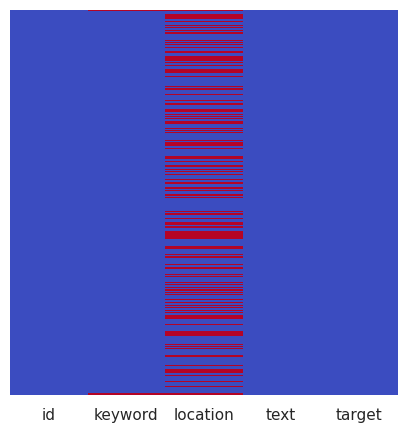

In [6]:
sns.set(rc={'figure.figsize':(5,5)})
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap="coolwarm")

Analysis and Visualisation of Target Variable

Here each red line indicates there is missing value and as per heat map of keyword and location have missing value.
As for NLP model building we will be using only text and target, so there is no need to handle missing value.

In [7]:
df['target'].value_counts()
#tells the occurance of 0 & 1 in target column

target
0    4342
1    3271
Name: count, dtype: int64

Text(0.5, 1.0, 'Target Distributions \n (0: Non Disaster, 1: Disaster)')

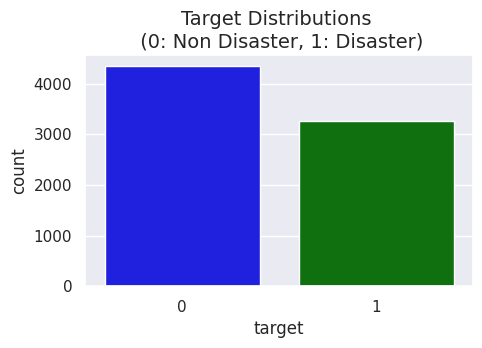

In [8]:
plt.figure(figsize=(5,3))
colors = ["blue", "green"]

sns.countplot(x = 'target', data=df, palette=colors)
plt.title('Target Distributions \n (0: Non Disaster, 1: Disaster)', fontsize=14)

In [9]:
df["keyword"].nunique()
#gives the number of total unique value i.e. 221

221

Plotting word cloud for top 50 keywords appearing in the dataset

In [10]:
disaster_data = df[df['target'] == 1]['text']
non_disaster_data = df[df['target'] == 0]['text']

In [11]:
from wordcloud import WordCloud

# Function to generate word cloud for a given text data
def generate_wordcloud(data, title):
    wordcloud = WordCloud(width = 600, height = 600,
                          background_color ='black',
                          min_font_size = 10).generate(' '.join(data))

    plt.figure(figsize = (6, 6), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.title(title)
    plt.show()

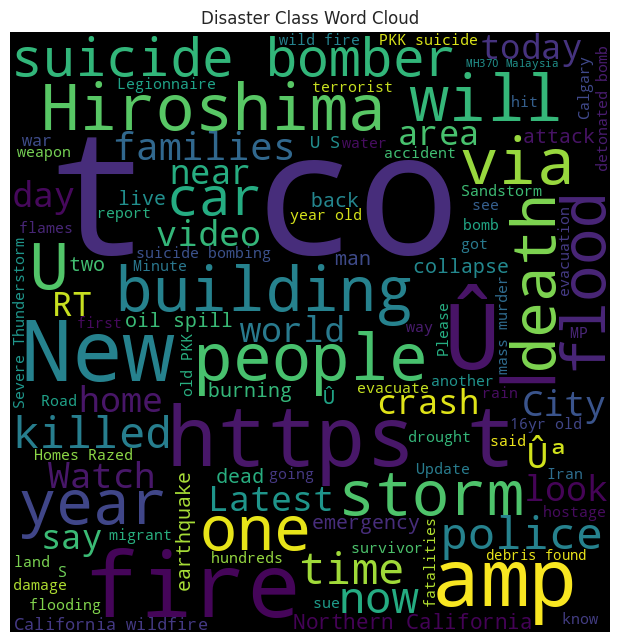

In [12]:
generate_wordcloud(disaster_data, 'Disaster Class Word Cloud')

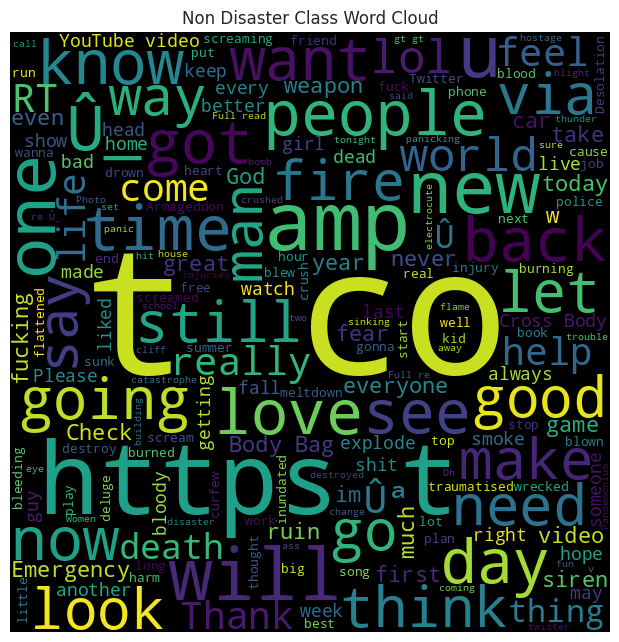

In [13]:
generate_wordcloud(non_disaster_data, 'Non Disaster Class Word Cloud')

Plotting top 20 keywords

Text(0.5, 0, 'Count of Keywords')

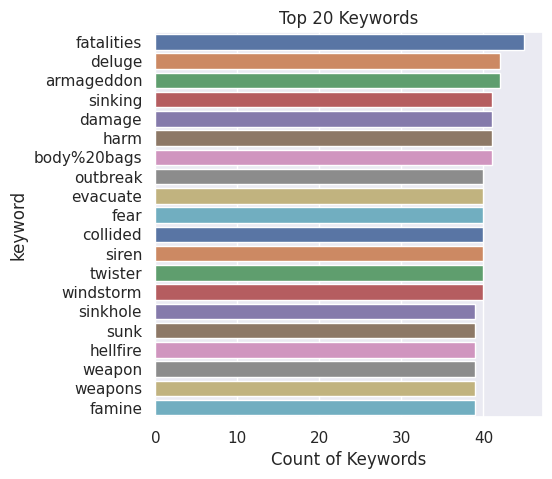

In [14]:
chains=df['keyword'].value_counts()[:20]
sns.barplot(x=chains,y=chains.index,palette='deep')
plt.title("Top 20 Keywords")
plt.xlabel("Count of Keywords")
#we plotted top 20 keywords with their counts like the "fatalities" keyword appread for nearly 50 times.

Plotting top 20 disaster and non disaster keywords

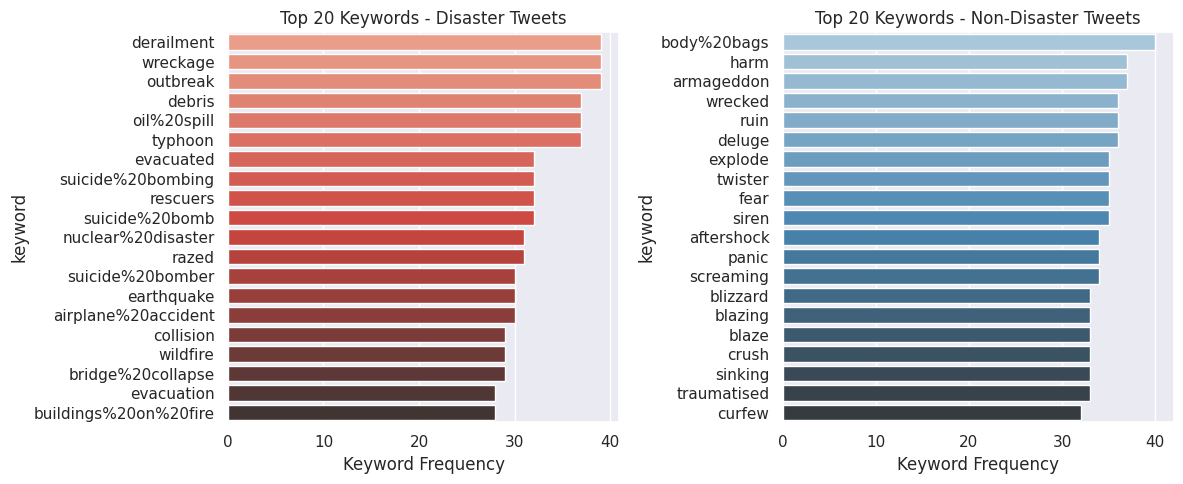

In [15]:
disaster_keywords = df.loc[df["target"] == 1]["keyword"].value_counts()
nondisaster_keywords = df.loc[df["target"] == 0]["keyword"].value_counts()

fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.barplot(y=disaster_keywords[0:20].index, x=disaster_keywords[0:20], orient='h', ax=ax[0], palette="Reds_d")
ax[0].set_title("Top 20 Keywords - Disaster Tweets")
ax[0].set_xlabel("Keyword Frequency")

sns.barplot(y=nondisaster_keywords[0:20].index, x=nondisaster_keywords[0:20], orient='h', ax=ax[1], palette="Blues_d")
ax[1].set_title("Top 20 Keywords - Non-Disaster Tweets")
ax[1].set_xlabel("Keyword Frequency")

plt.tight_layout()
plt.show()

Plotting top 20 locations of tweets

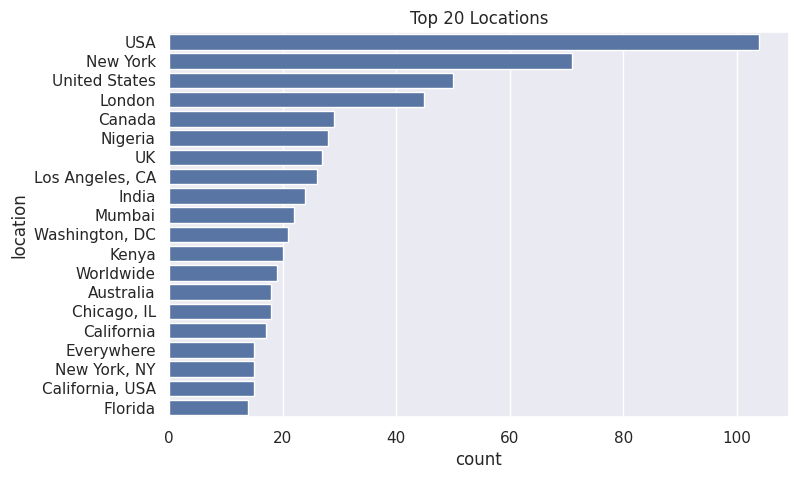

In [16]:
locations = df["location"].value_counts()
plt.figure(figsize=(8,5))
sns.barplot(y=locations[0:20].index, x=locations[0:20], orient='h')
plt.title("Top 20 Locations")
plt.show()

In [17]:
print(len(df['text']))

7613


In [18]:
#We created a column length in dataset, which will have length of each text.
df["length"]  = df["text"].apply(len)
df.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


In [19]:
df['length'].describe()

count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

In [20]:
df[df['length']==157]['text'].iloc[0]
#Here the maximum length word is having repeated punctuations. So the important information delivered is very less.

"when you're taking a shower and someone flushes the toilet and you have .1 second to GTFO or you get burned??????????????????????????????????????????????????"

Plotting tweets length

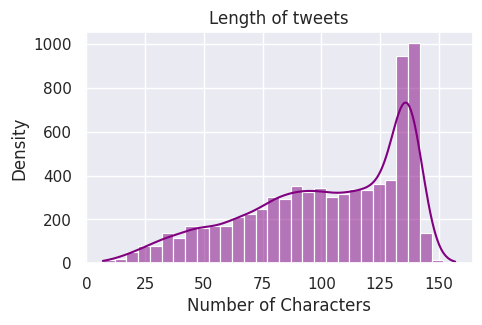

In [21]:
plt.figure(figsize=(5,3))
sns.histplot(df["length"], kde=True,color='purple',bins=30)
plt.title("Length of tweets")
plt.xlabel("Number of Characters")
plt.ylabel("Density")
plt.show()

Plotting tweets length wrt target

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

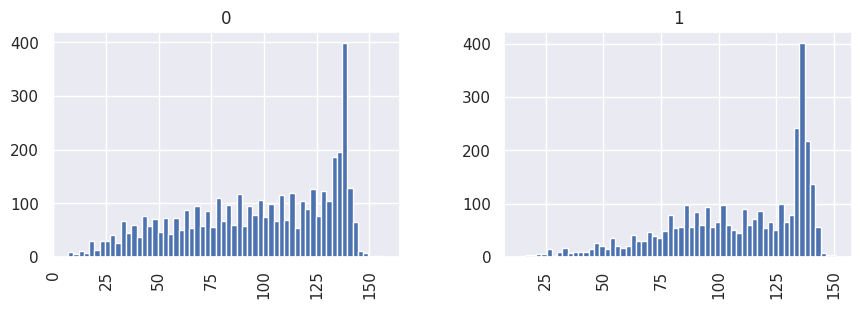

In [22]:
df.hist(column='length', by = 'target',bins =60, figsize= (10,3))

Plotting number of words in tweets

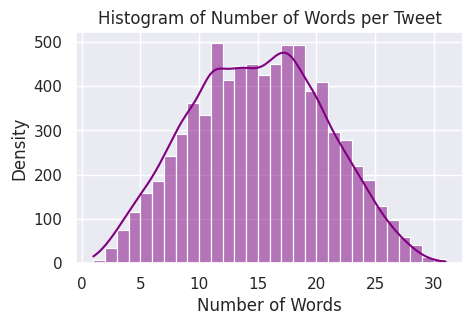

In [23]:
#Column "num_word" is created, which will have number of words in each tweet.
def count_words(x):
    return len(x.split())
df["num_words"] = df["text"].apply(count_words)
plt.figure(figsize=(5,3))
sns.histplot(df["num_words"],kde=True,color='purple',bins=30)
plt.title("Histogram of Number of Words per Tweet")
plt.xlabel("Number of Words")
plt.ylabel("Density")
plt.show()

In [24]:
df.head()

,id,keyword,location,text,target,length,num_words
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16


Plotting number of words in tweets wrt target

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

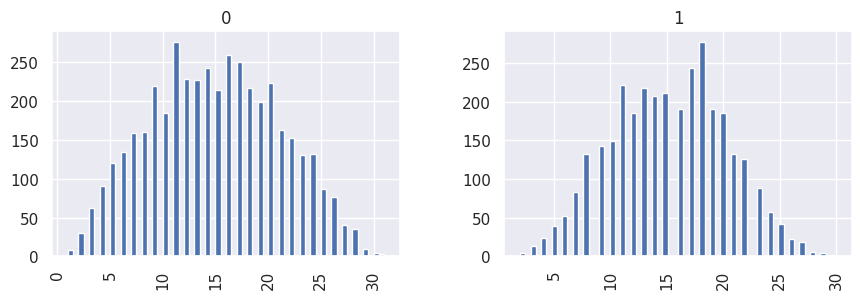

In [25]:
df.hist(column='num_words', by = 'target',bins =60, figsize= (10,3))

In [26]:
import string
import re

Text Preprocessing

In [27]:
#Removing Punctuations
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [28]:
# created a function 'toclean_text' to remove punctuations, and then it is used to clean text column of training data.
def toclean_text(text):
    clean_text = [char for char in text if char not in string.punctuation]
    clean_text = ''.join(clean_text)
    return clean_text

In [29]:
#Function 'toclean_text', remove punctuations in a text. Now we apply it to training data and create a column clean_text for the training data, which will have text without puntuations.
df['clean_text'] = df['text'].apply(toclean_text)

In [30]:
df.head()

,id,keyword,location,text,target,length,num_words,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13,Our Deeds are the Reason of this earthquake Ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7,Forest fire near La Ronge Sask Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22,All residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8,13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16,Just got sent this photo from Ruby Alaska as s...


Removing Noise

Noise in a text can be considered as anything which does belong to normal human language interaction.

Noise in the text can generally be considered as URL, abbreviations, emojis, message inside HTML tag, etc.

The main reason why abbreviations are included as noise is that some people write thx for thankyou. If abbreviations are not replaced with the original word, 'thx' and 'thankyou' will be considered as two different words.

In [31]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk",
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart",
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet",
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously",
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [32]:
# Removing all URLs, replacing by URL
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL',text)

# Removing HTML beacon
def remove_HTML(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

# Removing non printable characters
def remove_not_ASCII(text):
    text = ''.join([word for word in text if word in string.printable])
    return text

# Change an abbreviation by its true meaning
def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

# Removing all abbreviations
def replace_abbrev(text):
    string = ""
    for word in text.split():
        string += word_abbrev(word) + " "
    return string

# Removing @ and mention, replacing by USER
def remove_mention(text):
    at=re.compile(r'@\S+')
    return at.sub(r'USER',text)

# Removing numbers, replacing it by NUMBER
def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)

# Removing all emojis, replacing by EMOJI
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'EMOJI', text)

# Removing some others smileys with SADFACE
def transcription_sad(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[(\\/]')
    return smiley.sub(r'SADFACE', text)

# Removing some smileys with SMILE
def transcription_smile(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[)dDp]')
    return smiley.sub(r'SMILE', text)

# Removing <3 with HEART
def transcription_heart(text):
    heart = re.compile(r'<3')
    return heart.sub(r'HEART', text)

In [33]:
#Function clean_tweet() removes all the noise in the text.
def clean_tweet(text):

    # Remove non text
    text = remove_URL(text)
    text = remove_HTML(text)
    text = remove_not_ASCII(text)

    # replace abbreviations, @ and number
    text = replace_abbrev(text)
    text = remove_mention(text)
    text = remove_number(text)

    # Remove emojis / smileys
    text = remove_emoji(text)
    text = transcription_sad(text)
    text = transcription_smile(text)
    text = transcription_heart(text)

    return text

In [34]:
df["clean_text"] = df["clean_text"].apply(clean_tweet)

In [35]:
df.head()

,id,keyword,location,text,target,length,num_words,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13,Our Deeds are the Reason of this earthquake Ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7,Forest fire near La Ronge Sask Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22,All residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8,NUMBER people receive wildfires evacuation ord...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16,Just got sent this photo from Ruby Alaska as s...


In [36]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Removing Stopwords

Stopwords are commonly used words, which do not have any core meaning like "a", "an", "the", so on…


In [37]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [38]:
def toremove_stopword(text):
    remove_stopword = [word for word in text.split() if word.lower() not in stopwords.words('english')]

    return remove_stopword

In [39]:
df['clean_text'] = df['clean_text'].apply(toremove_stopword)

In [40]:
df.head()

,id,keyword,location,text,target,length,num_words,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13,"[Deeds, Reason, earthquake, May, ALLAH, Forgiv..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7,"[Forest, fire, near, La, Ronge, Sask, Canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22,"[residents, asked, shelter, place, notified, o..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8,"[NUMBER, people, receive, wildfires, evacuatio..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16,"[got, sent, photo, Ruby, Alaska, smoke, wildfi..."


In [41]:
!pip install livelossplot

By using TF-IDF

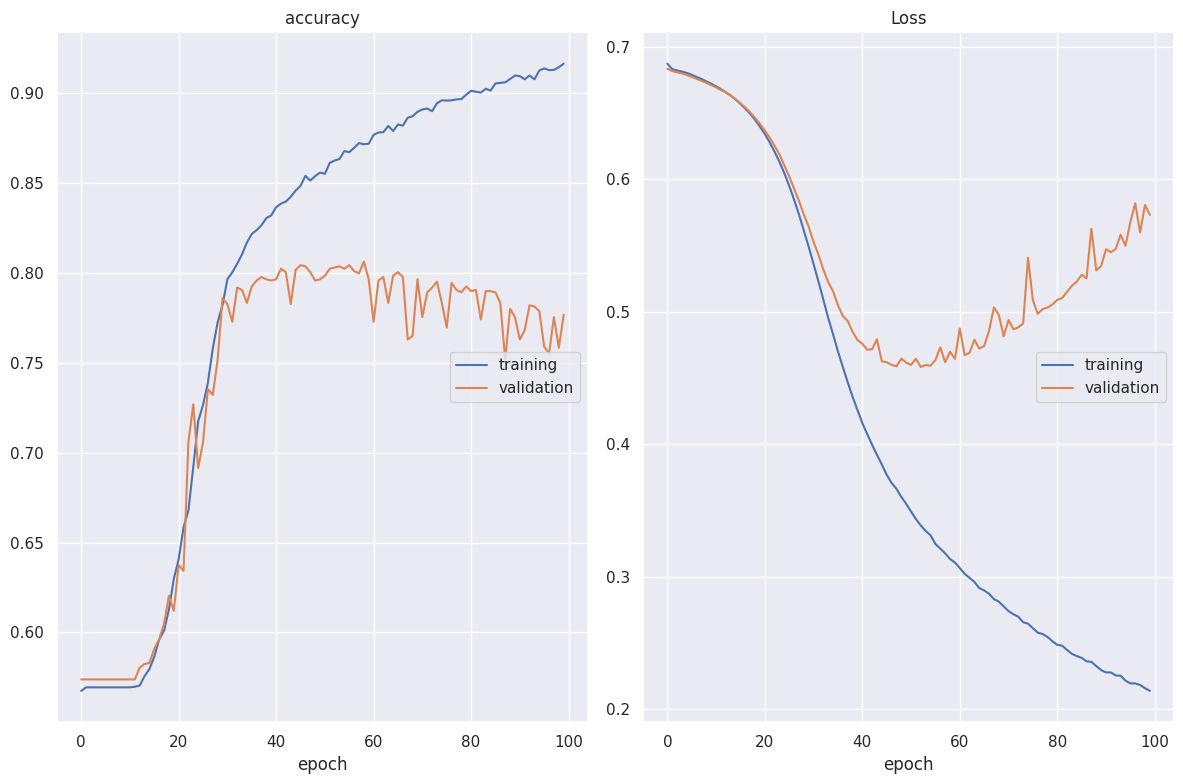

accuracy
	training         	 (min:    0.567, max:    0.916, cur:    0.916)
	validation       	 (min:    0.574, max:    0.806, cur:    0.777)
Loss
	training         	 (min:    0.214, max:    0.687, cur:    0.214)
	validation       	 (min:    0.458, max:    0.684, cur:    0.573)
48/48 [==============================] - 0s 2ms/step - loss: 0.5731 - accuracy: 0.7768
Test Accuracy: 0.7767564058303833


In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
import tensorflow as tf
from livelossplot import PlotLossesKerasTF

clean_text_strings = [' '.join(map(str, item)) if isinstance(item, list) else item for item in df['clean_text'].values]

tfidf_vectorizer = TfidfVectorizer(max_features=3000)
X_tfidf = tfidf_vectorizer.fit_transform(clean_text_strings)
X = X_tfidf.toarray()
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1,callbacks=[PlotLossesKerasTF()])

test_loss, test_accuracy_tfidf = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy_tfidf)

In [45]:
y_pred_probs = model.predict(X_test)


y_pred_binary = (y_pred_probs > 0.5).astype(int)


conf_matrix = confusion_matrix(y_test, y_pred_binary)

print("Confusion Matrix:")
print(conf_matrix)

48/48 [==============================] - 1s 6ms/step
Confusion Matrix:
[[756 118]
 [222 427]]


In [48]:
class_report = classification_report(y_test, y_pred_binary)

print("\nClassification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.86      0.82       874
           1       0.78      0.66      0.72       649

    accuracy                           0.78      1523
   macro avg       0.78      0.76      0.77      1523
weighted avg       0.78      0.78      0.77      1523



In [ ]:
model.save("model.h5")

## By using Bag of Words(BOW)

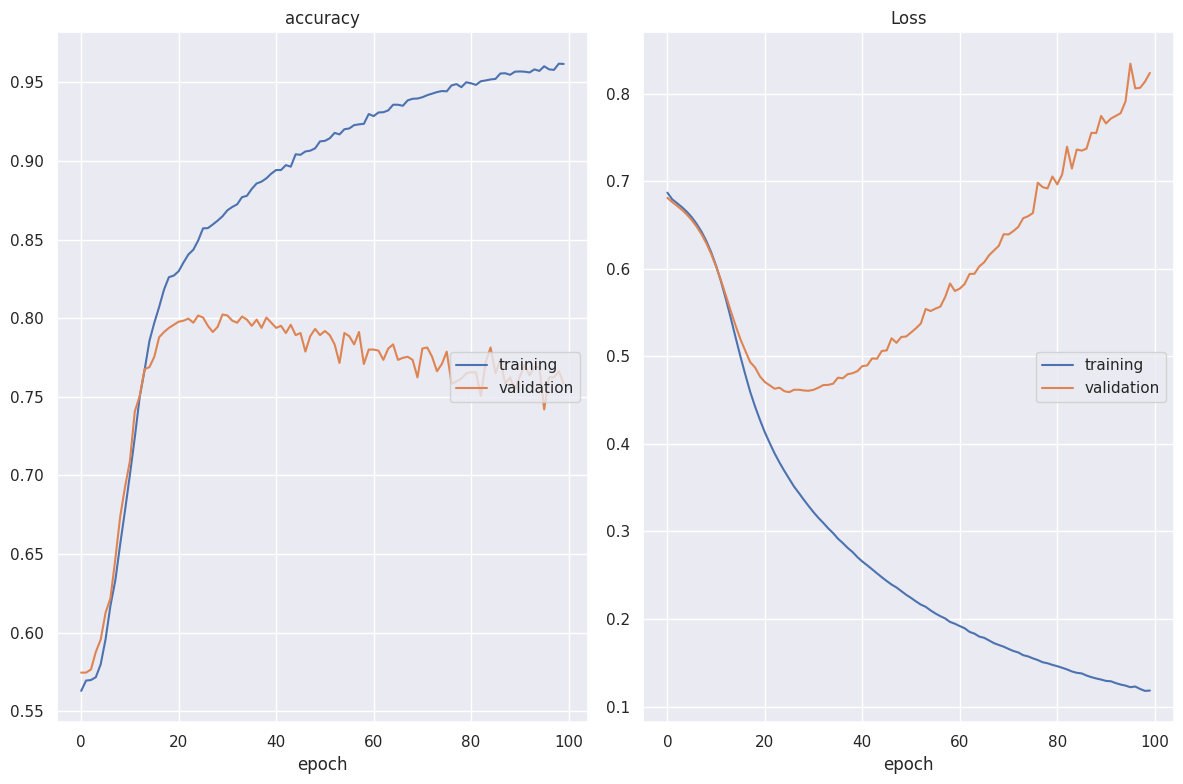

accuracy
	training         	 (min:    0.563, max:    0.962, cur:    0.962)
	validation       	 (min:    0.575, max:    0.802, cur:    0.758)
Loss
	training         	 (min:    0.118, max:    0.687, cur:    0.118)
	validation       	 (min:    0.459, max:    0.834, cur:    0.824)
48/48 [==============================] - 0s 2ms/step - loss: 0.8236 - accuracy: 0.7584
Test Accuracy: 0.7583716511726379


In [49]:
from sklearn.feature_extraction.text import CountVectorizer


clean_text_strings = [' '.join(map(str, item)) if isinstance(item, list) else item for item in df['clean_text'].values]

count_vectorizer = CountVectorizer(max_features=3000)
X_bag_of_words = count_vectorizer.fit_transform(clean_text_strings)
X = X_bag_of_words.toarray()
y = df['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model1 = Sequential()
model1.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model1.add(Dense(4, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
history = model1.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[PlotLossesKerasTF()])

test_loss, test_accuracy_BOW = model1.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy_BOW)

In [50]:
y_pred_probs = model.predict(X_test)


y_pred_binary = (y_pred_probs > 0.5).astype(int)


conf_matrix = confusion_matrix(y_test, y_pred_binary)

print("Confusion Matrix:")
print(conf_matrix)

48/48 [==============================] - 0s 3ms/step
Confusion Matrix:
[[639 235]
 [143 506]]


In [51]:
class_report = classification_report(y_test, y_pred_binary)

print("\nClassification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.73      0.77       874
           1       0.68      0.78      0.73       649

    accuracy                           0.75      1523
   macro avg       0.75      0.76      0.75      1523
weighted avg       0.76      0.75      0.75      1523



### Using LSTM

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np



max_features = 10000
sequence_length = 100


tokenizer = Tokenizer(num_words=max_features, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])
X_tokenized = tokenizer.texts_to_sequences(df['text'])


X_padded = pad_sequences(X_tokenized, maxlen=sequence_length, padding='post', truncating='post')


X = np.array(X_padded)
y = df['target'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)


embedding_dim = 32
model2 = Sequential([
    Embedding(input_dim=max_features + 1, output_dim=embedding_dim, mask_zero=True),
    LSTM(64, activation='tanh', return_sequences=True),
    LSTM(32, activation='tanh'),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])


model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model2.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))



Epoch 1/10
191/191 [==============================] - 37s 154ms/step - loss: 0.5338 - accuracy: 0.7388 - val_loss: 0.4469 - val_accuracy: 0.8017
Epoch 2/10
191/191 [==============================] - 25s 131ms/step - loss: 0.3387 - accuracy: 0.8647 - val_loss: 0.4298 - val_accuracy: 0.8129
Epoch 3/10
191/191 [==============================] - 27s 140ms/step - loss: 0.2470 - accuracy: 0.9041 - val_loss: 0.5440 - val_accuracy: 0.7866
Epoch 4/10
191/191 [==============================] - 25s 133ms/step - loss: 0.1913 - accuracy: 0.9338 - val_loss: 0.5571 - val_accuracy: 0.7800
Epoch 5/10
191/191 [==============================] - 27s 139ms/step - loss: 0.1509 - accuracy: 0.9491 - val_loss: 0.7077 - val_accuracy: 0.7708
Epoch 6/10
191/191 [==============================] - 29s 154ms/step - loss: 0.1258 - accuracy: 0.9575 - val_loss: 0.7977 - val_accuracy: 0.7807
Epoch 7/10
191/191 [==============================] - 32s 166ms/step - loss: 0.0998 - accuracy: 0.9672 - val_loss: 0.9946 - val_ac

In [54]:

y_pred_probs_lstm = model2.predict(X_test)

y_pred_binary_lstm = (y_pred_probs_lstm > 0.5).astype(int)

conf_matrix_lstm = confusion_matrix(y_test, y_pred_binary_lstm)

print("Confusion Matrix (LSTM):")
print(conf_matrix_lstm)

48/48 [==============================] - 6s 27ms/step
Confusion Matrix (LSTM):
[[716 151]
 [197 459]]


In [55]:
class_report_lstm = classification_report(y_test, y_pred_binary_lstm)

print("\nClassification Report (LSTM):")
print(class_report_lstm)


Classification Report (LSTM):
              precision    recall  f1-score   support

           0       0.78      0.83      0.80       867
           1       0.75      0.70      0.73       656

    accuracy                           0.77      1523
   macro avg       0.77      0.76      0.76      1523
weighted avg       0.77      0.77      0.77      1523



### Using Bi-LSTM

In [56]:

# Define custom text standardization function
def custom_standardization(input_data):
    lowercase = input_data.lower()
    # Add additional preprocessing steps as needed
    return lowercase

# Tokenize the text data
max_features = 10000
sequence_length = 100
tokenizer = Tokenizer(num_words=max_features, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])
X_tokenized = tokenizer.texts_to_sequences(df['text'])

# Pad sequences to ensure uniform length
X_padded = pad_sequences(X_tokenized, maxlen=sequence_length, padding='post', truncating='post')

# Vectorize the text data
X = np.array(X_padded)
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state =41)

embedding_dim = 32
model3 = Sequential([
    Embedding(input_dim=max_features + 1, output_dim=embedding_dim , mask_zero=True),
    Bidirectional(LSTM(32, activation='tanh')),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [57]:
# Compile the model
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train the model
history = model3.fit(X_train, y_train, epochs=10 , batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
191/191 [==============================] - 34s 136ms/step - loss: 0.5679 - accuracy: 0.6926 - val_loss: 0.4290 - val_accuracy: 0.8011
Epoch 2/10
191/191 [==============================] - 23s 119ms/step - loss: 0.3437 - accuracy: 0.8603 - val_loss: 0.4296 - val_accuracy: 0.8030
Epoch 3/10
191/191 [==============================] - 22s 115ms/step - loss: 0.2298 - accuracy: 0.9144 - val_loss: 0.5588 - val_accuracy: 0.7925
Epoch 4/10
191/191 [==============================] - 21s 113ms/step - loss: 0.1459 - accuracy: 0.9468 - val_loss: 0.6964 - val_accuracy: 0.7571
Epoch 5/10
191/191 [==============================] - 21s 109ms/step - loss: 0.0901 - accuracy: 0.9637 - val_loss: 0.8235 - val_accuracy: 0.7761
Epoch 6/10
191/191 [==============================] - 22s 113ms/step - loss: 0.0641 - accuracy: 0.9700 - val_loss: 1.2292 - val_accuracy: 0.7538
Epoch 7/10
191/191 [==============================] - 22s 116ms/step - loss: 0.0554 - accuracy: 0.9742 - val_loss: 1.5274 - val_ac

In [58]:
y_pred_probs_lstm = model3.predict(X_test)

y_pred_binary_lstm = (y_pred_probs_lstm > 0.5).astype(int)

conf_matrix_lstm = confusion_matrix(y_test, y_pred_binary_lstm)

print("Confusion Matrix (LSTM):")
print(conf_matrix_lstm)

48/48 [==============================] - 5s 24ms/step
Confusion Matrix (LSTM):
[[692 175]
 [180 476]]


In [59]:
class_report_lstm = classification_report(y_test, y_pred_binary_lstm)

print("\nClassification Report (LSTM):")
print(class_report_lstm)


Classification Report (LSTM):
              precision    recall  f1-score   support

           0       0.79      0.80      0.80       867
           1       0.73      0.73      0.73       656

    accuracy                           0.77      1523
   macro avg       0.76      0.76      0.76      1523
weighted avg       0.77      0.77      0.77      1523



48/48 [==============================] - 3s 59ms/step - loss: 1.1644 - accuracy: 0.7669


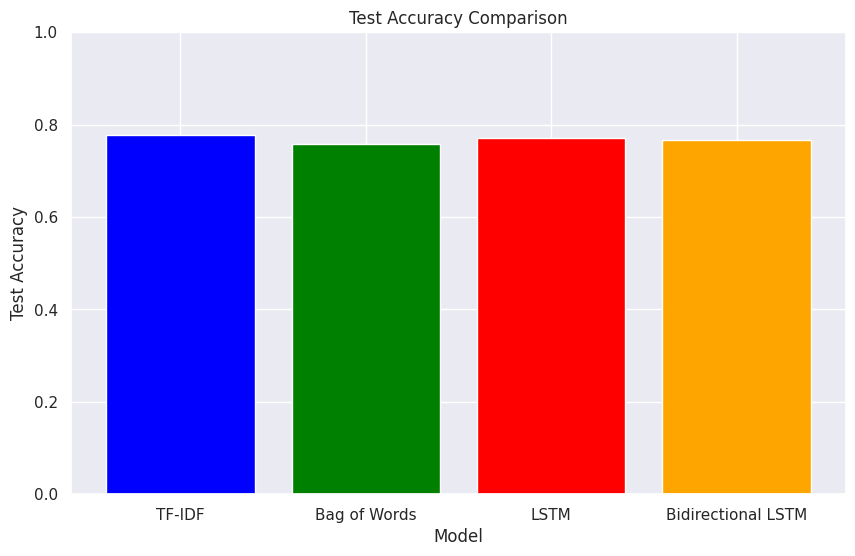

In [60]:

epochs_tfidf = len(history.history['accuracy'])
epochs_bow = len(history.history['accuracy'])
epochs_lstm = 10
epochs_bilstm = 10


test_accuracy = [test_accuracy_tfidf, test_accuracy_BOW, model2.evaluate(X_test, y_test)[1], model3.evaluate(X_test, y_test)[1]]

plt.figure(figsize=(10, 6))
models = ['TF-IDF', 'Bag of Words', 'LSTM', 'Bidirectional LSTM']
plt.bar(models, test_accuracy, color=['blue', 'green', 'red', 'orange'])
plt.title('Test Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1)
plt.show()

In [ ]:
model.save("model.h5")

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np

def predict_disaster(tweet_text, model_path, tfidf_vectorizer):

    model = load_model(model_path)

    cleaned_tweet = clean_tweet(tweet_text)
    cleaned_tweet_without_stopwords = ' '.join(toremove_stopword(cleaned_tweet))


    tfidf_vector = tfidf_vectorizer.transform([cleaned_tweet_without_stopwords])
    tfidf_vector_array = tfidf_vector.toarray()

    prediction = model.predict(tfidf_vector_array)


    result = "Disaster" if prediction > 0.5 else "Not a disaster"

    return result


model_path = "model.h5"

user_tweet = input("Please enter your tweet: ")
prediction = predict_disaster(user_tweet, model_path, tfidf_vectorizer)
print("Prediction:", prediction)


Please enter your tweet: @sunkxssedharry will you wear shorts for race ablaze ?


1/1 [==============================] - 0s 98ms/step
Prediction: Not a disaster
